# **Import Libraires**

In [47]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import re 
import os
from PIL import Image

In [48]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import multiprocess
import psutil

# **Data Preprocessing**

## **Building Up the Dataset**

(512, 640, 3) (512, 640, 3)


(-0.5, 639.5, 511.5, -0.5)

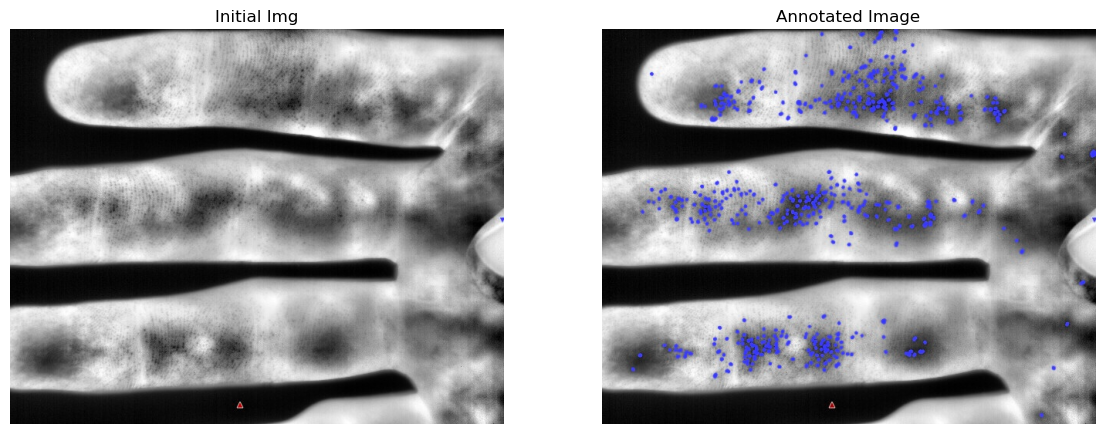

In [49]:
# Import data 
image_path = '/Users/rickysu/Projects/sweatPoresActivation/input_images/raw/8.bmp'
img = cv2.imread(image_path)

annotated_img_path = '/Users/rickysu/Projects/sweatPoresActivation/input_images/annoted/8.bmp'
annotated_img = cv2.imread(annotated_img_path)

print(img.shape, annotated_img.shape) # make sure two images are in the same shape

# show the image 
plt.figure(figsize = (14, 8))

plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.title("Initial Img")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(annotated_img, cmap = 'gray')
plt.title("Annotated Image")
plt.axis("off")

16 20


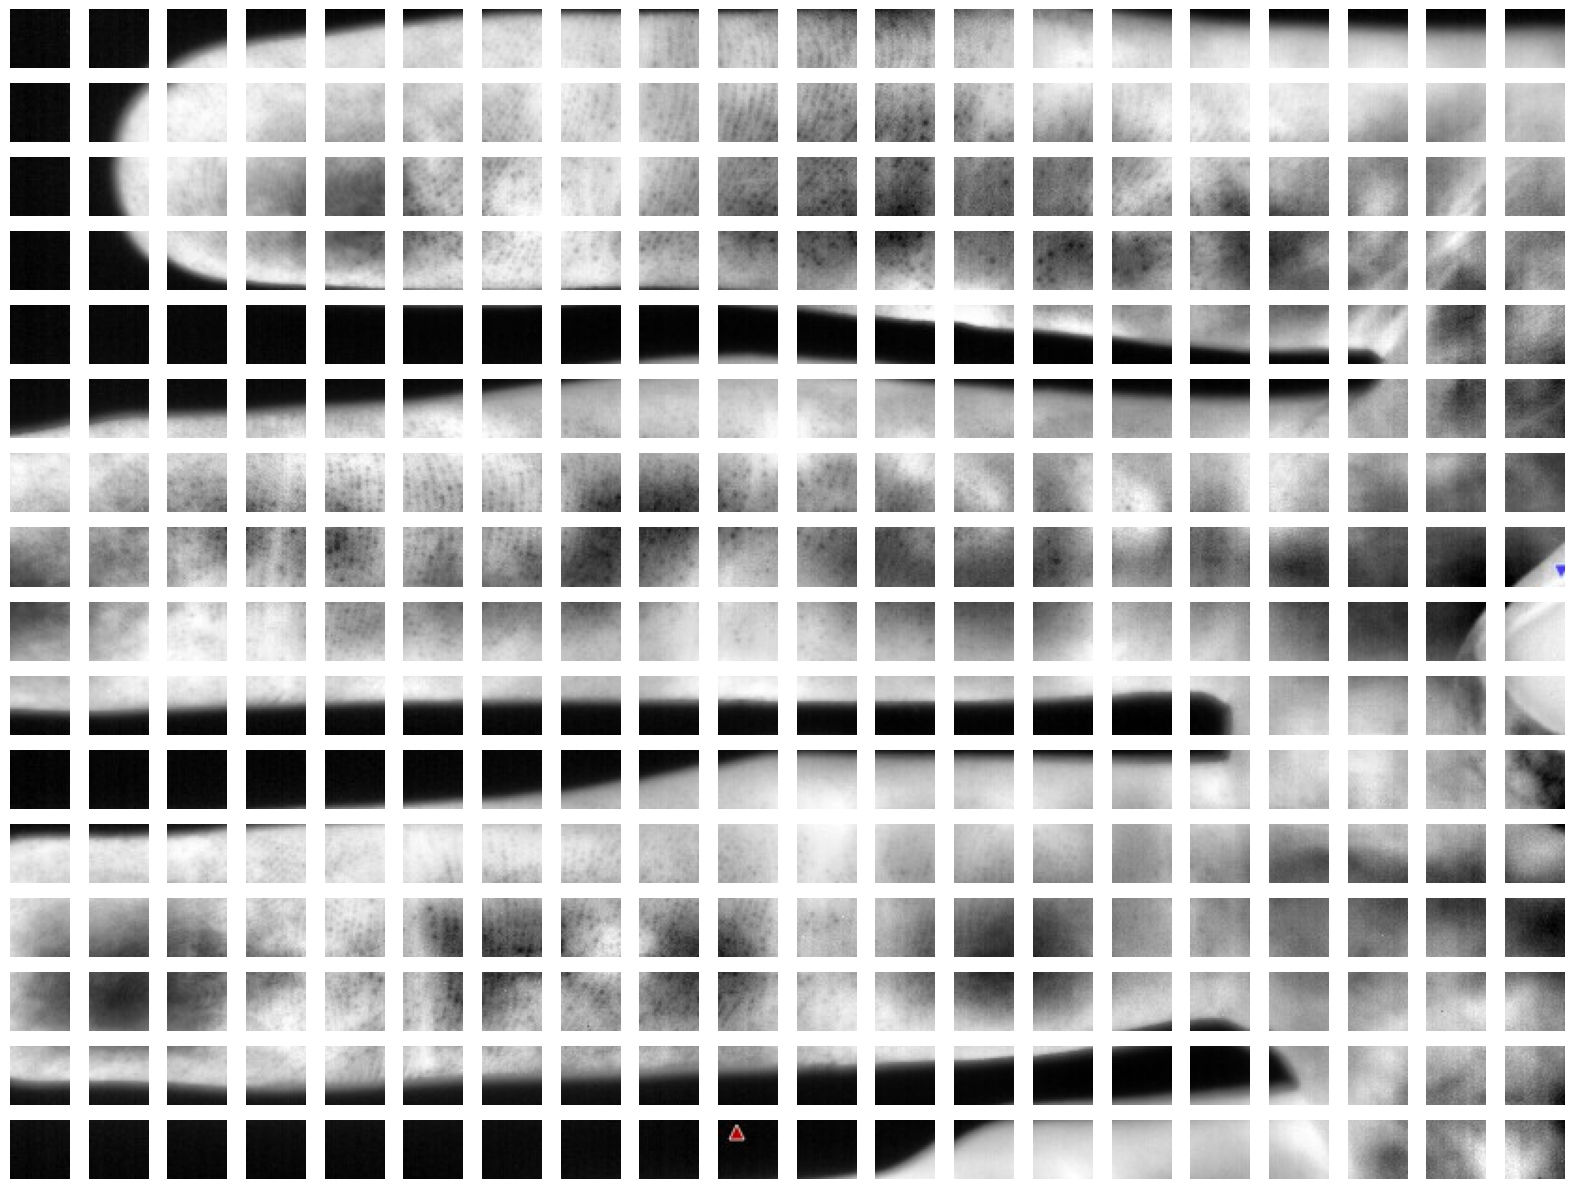

In [50]:
# Get the shape of the image
img_height, img_width, _ = img.shape

# Define the size of each subgrid
subgrid_height = 32
subgrid_width = 32

# Calculate the number of subgrids in each dimension
num_subgrids_height = img_height // subgrid_height
num_subgrids_width = img_width // subgrid_width

print(num_subgrids_height, num_subgrids_width)

# Create a figure and axes for displaying the subgrids
fig, axes = plt.subplots(num_subgrids_height, num_subgrids_width, figsize=(16, 12))
plt.tight_layout()

# Iterate over each subgrid and display it as an image
for i in range(num_subgrids_height):
    for j in range(num_subgrids_width):
        subgrid = img[i*subgrid_height:(i+1)*subgrid_height, j*subgrid_width:(j+1)*subgrid_width, :]
        axes[i, j].imshow(subgrid)
        axes[i, j].axis('off')
        #axes[i, j].set_title(f"Subgrid ({i}, {j})")

# Display the figure with subgrids
plt.tight_layout()
plt.show()

Total images: 320
First item in the image_files: 8.bmp_79_0.png <class 'str'>
Image label: 0



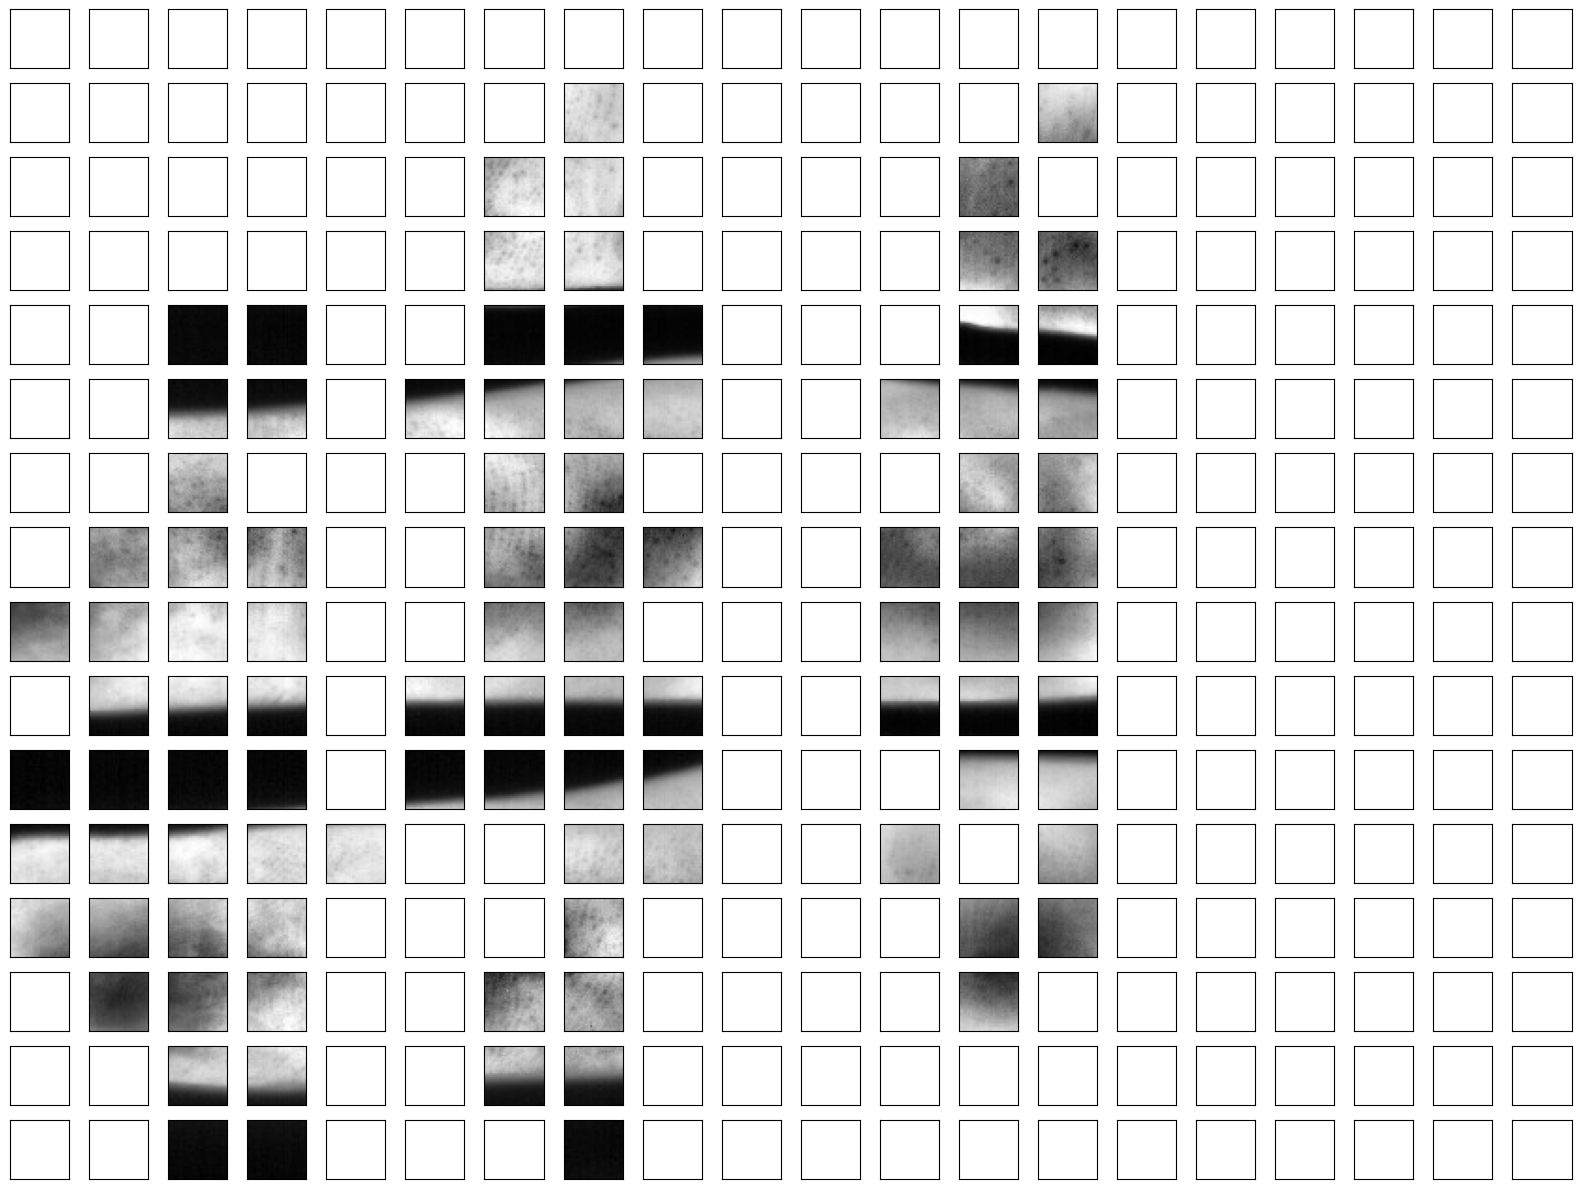

In [51]:
# Set up the grid
rows =16
cols = 20
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))

# Path to your image folder
folder_path = '/Users/rickysu/Projects/sweatPoresActivation/results/batchesSize/32X32'

# Get a list of image files in the folder
image_files = os.listdir(folder_path)
print(f"Total images: {len(image_files)}")
print("First item in the image_files:",image_files[0], type(image_files[0]))
label = image_files[0].split('_')[-1].split('.')[0]
print("Image label:", label)
print()



# Function to get order number and label from filename
def get_order_and_label(filename):
    match = re.search(r'_(\d+)_(\d+)', filename)
    return int(match.group(1)), int(match.group(2))



# Sort the image files based on the order number
image_files.sort(key=lambda x: get_order_and_label(x)[0])

# Create a blank white image
blank_image = np.ones((52, 52, 3), dtype=np.uint8) * 255  # Assuming 52x52 is your image size

# Iterate through the grid
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < len(image_files):
            # Get the label from the filename
            _, label = get_order_and_label(image_files[index])
            
            if label == 1:
                # Load and display the image with label 1
                img_path = os.path.join(folder_path, image_files[index])
                img = Image.open(img_path)
                img_array = np.array(img)
                axes[i, j].imshow(img_array, cmap='gray' if img_array.ndim == 2 else None)
            else:
                # Display a blank white image for other labels
                axes[i, j].imshow(blank_image, cmap='gray')
        else:
            # Display a blank white image if there are no more images
            axes[i, j].imshow(blank_image, cmap='gray')
        
        # Remove axis 
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

## **Custom Dataset in Pytorch**
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. 

- The **Dataset** 
1. Stores the samples and their corresponding labels. 
2. Retrieves our dataset’s features and labels one sample at a time. 

In [52]:
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image


# Inherit from dataset 
class SweatPoresDataset(Dataset):
    def __init__(self, img_dir, transforms = None):
        """
        It is run once when instantiating the Dataset object. 
        """
        self.img_dir = img_dir
        self.transform = transforms
        self.img_files = os.listdir(img_dir) # list of image files

    def __len__(self):
        """
        It returns the number of samples in our dataset
        """
        return len(self.img_files)

    def __getitem__(self, idx):
        """
        It loads and returns a smaple from the dataset at the given index
        """
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert('RGB') # Retrieve the image data 
        label = int(self.img_files[idx].split('_')[-1].split('.')[0]) # Etrack the label from the image
        img_name = self.img_files[idx] 

        if self.transform: 
            image = self.transform(image)


        return image, label, img_name


dataset = SweatPoresDataset(img_dir = '../results/batchesSize/32X32')


print(f"Type of dataset: {dataset}")
print(f"Total amount of data: {len(dataset)}")
print(f"First data item: {dataset[0]}")

Type of dataset: <__main__.SweatPoresDataset object at 0x32e87fbe0>
Total amount of data: 320
First data item: (<PIL.Image.Image image mode=RGB size=32x32 at 0x32E87F880>, 0, '8.bmp_79_0.png')


## **Apply Transformation**
Every thing in Deep Learning is in the form of Tensors. Converting images to tensors is essential for compatibility with deep learning frameworks. Additionally we should also normalized the input images which helps ensure consistency in the input distribution, so that all the tensors are in the same range of [-1, 1]. We can use the method providied by **torchvision.transforms** to do this. 

- Normalization Formula: $\frac{\text{input} - \text{mean}}{\text{std}}$

In [53]:
trans = transforms.Compose([
    transforms.ToTensor(), # Convert data to Tensor for dataloader
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # scale the pixel values of the image between -1 and 1
])

In [54]:
# Apply transformation
dataset = SweatPoresDataset(img_dir = '../results/batchesSize/32X32', transforms = trans)


print(f"Type of dataset: {dataset}")
print(f"Total amount of data: {len(dataset)}")
print(f"First data item: {dataset[0]}")

Type of dataset: <__main__.SweatPoresDataset object at 0x32e87e2c0>
Total amount of data: 320
First data item: (tensor([[[ 0.0118,  0.0196,  0.0745,  ...,  0.1608,  0.2157,  0.1216],
         [ 0.0353,  0.0745,  0.1608,  ...,  0.1137,  0.0980,  0.1294],
         [-0.0510,  0.0510,  0.2157,  ...,  0.1529,  0.0824,  0.1373],
         ...,
         [ 0.2078,  0.2000,  0.1294,  ..., -0.4745, -0.4510, -0.2784],
         [ 0.1843,  0.2314,  0.2157,  ..., -0.4667, -0.4902, -0.4745],
         [ 0.3255,  0.2941,  0.3882,  ..., -0.5059, -0.5137, -0.4667]],

        [[ 0.0118,  0.0196,  0.0745,  ...,  0.1608,  0.2157,  0.1216],
         [ 0.0353,  0.0745,  0.1608,  ...,  0.1137,  0.0980,  0.1294],
         [-0.0510,  0.0510,  0.2157,  ...,  0.1529,  0.0824,  0.1373],
         ...,
         [ 0.2078,  0.2000,  0.1294,  ..., -0.4745, -0.4510, -0.2784],
         [ 0.1843,  0.2314,  0.2157,  ..., -0.4667, -0.4902, -0.4745],
         [ 0.3255,  0.2941,  0.3882,  ..., -0.5059, -0.5137, -0.4667]],

    

## **Preparing Data for training with DataLoader**
**DataLoader** is an iterable that abstracts this complexity for us in an easy API.

While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.



In [55]:
from torch.utils.data import DataLoader

# The batch_size determines how many samples from the dataset will be processed together in a single iteration.
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Retval Type:  <class 'torch.Tensor'> <class 'torch.Tensor'>
Feature batch shape: torch.Size([8, 3, 32, 32]), Amount: 8
Labels batch shape: torch.Size([8]), Amount: 8
tensor([0, 0, 0, 0, 0, 1, 1, 0])


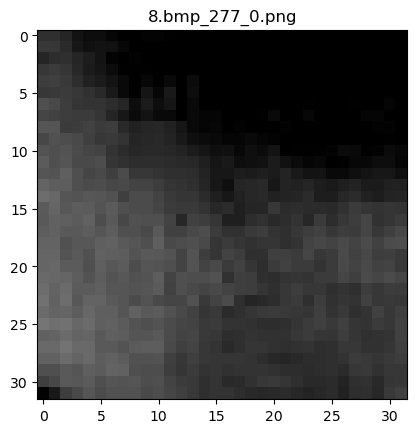

Label: 0


In [56]:
# Display image and label.
train_features, train_labels, train_features_names = next(iter(train_dataloader))

# Get more information from the return values
print("Retval Type: ", type(train_features), type(train_labels))
print(f"Feature batch shape: {train_features.size()}, Amount: {len(train_features)}")
print(f"Labels batch shape: {train_labels.size()}, Amount: {len(train_labels)}")
print(train_labels)

# Print the first data from dataloader
img = train_features[0].squeeze() 
# Tensor(3,32,32) ---> img(32,32,3)
img = img.permute(1, 2, 0)
label = train_labels[0]
plt.title(f"{train_features_names[0]}")
plt.imshow(img.numpy(), cmap="gray")
plt.show()
print(f"Label: {label}")

# **Convolutional Neural Networks**
- **Input Layer**
- **Convolutional Layer**
- **Activation Function**
- **Pooling Layer**
- **Flatten Layer**
- **Fully Connected Layer**
  1. Associate features to a particular label
  2. Classifiy the outputs, especially the output of the last fully connected layer has to have the same amount of neurons as the catogories we have
- **Output Layer**

In [86]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNNs(nn.Module):
    def __init__(self):
        # Call the initializer for the parent class
        super(SimpleCNNs, self).__init__()
        self.conv1 = nn.Conv2d(3,6,3)     # in_channnels = 3 / out_channels = 6 / kernel size = 5
        self.conv2 = nn.Conv2d(6,16,3)    # 6 ---> 16
        self.maxpool = nn.MaxPool2d(2, 2) # kernel size = 2 / strides = 2
        self.relu = nn.ReLU()
        # flatten out the channels(features) with width and height ---> C * W * H
        self.flatten = nn.Flatten(start_dim=1)  # it will return a 2D tensor, preserve the batch dimension and flatten everything else
        self.fc1 = nn.Linear(16 * 36, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 40)
        self.fc4 = nn.Linear(40,2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x) # Flatten the tensor, preserve the batch dimension and flatten everything else
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        x = F.softmax(x, dim=1) # Return the Probability
        
        return x

In [80]:
model = SimpleCNNs()
print(model)

SimpleCNNs(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=2, bias=True)
)


#### **Let's make sure all the layers are connected together with the same amount of coressponding neurons** 

In [59]:
# input
img_rand = torch.rand(3, 32, 32)
# layer 1
conv1 = nn.Conv2d(3, 6, 3)
img_rand = conv1(img_rand)
print(img_rand.shape)

mp = nn.MaxPool2d(2, 2)
img_rand = mp(img_rand)
print(img_rand.shape)
# layer 2
conv2 = nn.Conv2d(6, 16, 3)
img_rand = conv2(img_rand)
print(img_rand.shape)

img_rand = mp(img_rand)
print(img_rand.shape)


# With default paramete
m = nn.Flatten()
output = m(img_rand)
output.size()

torch.Size([6, 30, 30])
torch.Size([6, 15, 15])
torch.Size([16, 13, 13])
torch.Size([16, 6, 6])


torch.Size([16, 36])

In [81]:
# Test our CNNs
prediction = model(torch.rand(8, 3, 32, 32))
print(f"torch.Size([batch_size, num_features]):   {prediction.shape}")  # Outputs a tensor of 2, one tensor for each category of the image.

torch.Size([batch_size, num_features]):   torch.Size([8, 2])


## **Data Training**
- Train test split

In [61]:
from sklearn.model_selection import train_test_split

# Path to your folder containing images
data_dir = '/Users/rickysu/Projects/sweatPoresActivation/results/batchesSize/32X32'

# Get all image file names
image_files = os.listdir(data_dir)

# Apply transformation with my custom dataset 
dataset = SweatPoresDataset(img_dir = '../results/batchesSize/32X32', transforms = trans)

# Split the data
# Training: 80%
# Testing: 20%
train_data, test_data = train_test_split(dataset, test_size=0.2)

print(f"Total images: {len(dataset)}")
print(f"Training images dataset: {len(train_data)}")
print(f"Testing images dataset: {len(test_data)}")

Total images: 320
Training images dataset: 256
Testing images dataset: 64


In [62]:
# Pass data into dataloader 
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers = 4)

test_loader = DataLoader(test_data, batch_size = 8, shuffle = True, num_workers = 4)

In [63]:
# Testing out the dataloader
X, Y, Z = next(iter(train_loader))
print(f"Data: {X.shape}")
print(f"Lable: {Y[0]}")
print(f"Image names: {Z[0]}")

Data: torch.Size([8, 3, 32, 32])
Lable: 0
Image names: 8.bmp_258_0.png


In [64]:
[torch.cuda.is_available(), torch.backends.mps.is_available()]

[False, True]

In [82]:
# mps is avalible ! 
device = 'cpu'

model = model.to(device)
model

SimpleCNNs(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=2, bias=True)
)

## **Define the Loss Function and Optimizer**

In [66]:
import torch.optim as optim

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

## **Training Loop**

In [83]:
num_epochs = 15

train_loss = []
for epoch in range(num_epochs):
    # set the model to train
    model.train()
    running_loss = 0.0
    for images, labels, _ in train_loader:
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        # foward Propagation 
        optimizer.zero_grad() # Reset the gradient from the previous calculation
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Back Propagation ---> Update the model weights/bias in each steps
        loss.backward()
        optimizer.step()

        # Keep track of the running loss
        running_loss += loss.item() * labels.size(0)
        
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}")

print("Traing done")

Epoch 1/15 - Train loss: 0.684038694947958
Epoch 2/15 - Train loss: 0.6840386986732483
Epoch 3/15 - Train loss: 0.6840386986732483
Epoch 4/15 - Train loss: 0.6840386986732483
Epoch 5/15 - Train loss: 0.6840386968106031
Epoch 6/15 - Train loss: 0.6840386968106031
Epoch 7/15 - Train loss: 0.6840386968106031
Epoch 8/15 - Train loss: 0.6840387098491192
Epoch 9/15 - Train loss: 0.6840387098491192
Epoch 10/15 - Train loss: 0.6840386930853128
Epoch 11/15 - Train loss: 0.6840387042611837
Epoch 12/15 - Train loss: 0.6840387023985386
Epoch 13/15 - Train loss: 0.6840387061238289
Epoch 14/15 - Train loss: 0.6840387042611837
Epoch 15/15 - Train loss: 0.6840386930853128
Traing done


## **Model Evaluation**

In [84]:
model.eval()
feature1_probs = []
feature2_probs = []

with torch.no_grad():
    for inputs, _, _ in test_loader:
        outputs = model(inputs)
        probs = outputs.cpu().numpy()
        feature1_probs.extend(probs[:, 0])
        feature2_probs.extend(probs[:, 1])

print(f"Average probability of feature 1(No sweat pores): {np.mean(feature1_probs)*100:.2f}%")
print(f"Average probability of feature 2(Has sweat pores): {np.mean(feature2_probs)*100:.2f}%")

Average probability of feature 1(No sweat pores): 52.16%
Average probability of feature 2(Has sweat pores): 47.84%
